In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv("Camera_Traffic_Counts2_20250918.csv", usecols=["Month", "Hour", "Minute", "Day of Week", "Speed Average (Miles Per Hour)", "Volume", "Read Date"])

In [3]:
df['Read Date'] = pd.to_datetime(df['Read Date'], format='%m/%d/%Y %I:%M:%S %p')
df['time'] = df['Hour'] + df['Minute'] / 60
day_onehot = pd.get_dummies(df['Day of Week'], prefix='Day').astype(int)
df = pd.concat([df, day_onehot], axis=1)
df = df.drop(columns=['Day of Week'])  # drop original

features = ['time'] + list(day_onehot.columns)
print(df.head(3))

   Read Date  Volume  Speed Average (Miles Per Hour)  Month  Hour  Minute  \
0 2019-11-07       1                            11.0     11     0       0   
1 2019-11-07       1                             8.0     11     0       0   
2 2019-11-07       9                            27.0     11     0       0   

   time  Day_0  Day_1  Day_2  Day_3  Day_4  Day_5  Day_6  
0   0.0      0      0      0      0      1      0      0  
1   0.0      0      0      0      0      1      0      0  
2   0.0      0      0      0      0      1      0      0  


In [4]:
features = ['Day of Week', 'time']
target = 'Volume'

In [5]:
train_df = df[df['Month'] <= 10].sort_values('Read Date').reset_index(drop=True)
print(train_df.head())
test_df = df[df['Month'] > 10]

X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

   Read Date  Volume  Speed Average (Miles Per Hour)  Month  Hour  Minute  \
0 2019-01-01       5                          57.200      1     0       0   
1 2019-01-01       5                          20.200      1     0       0   
2 2019-01-01       2                          19.000      1     0       0   
3 2019-01-01       1                           0.000      1     0       0   
4 2019-01-01       3                          15.333      1     0       0   

   time  Day_0  Day_1  Day_2  Day_3  Day_4  Day_5  Day_6  
0   0.0      0      0      1      0      0      0      0  
1   0.0      0      0      1      0      0      0      0  
2   0.0      0      0      1      0      0      0      0  
3   0.0      0      0      1      0      0      0      0  
4   0.0      0      0      1      0      0      0      0  


In [6]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, PredefinedSplit

In [109]:
#Tuning hyperparameters
sample_size = 500000
train_sample = train_df.sample(n=sample_size, random_state=42)
train_sample = train_sample.sort_values('Read Date').reset_index(drop=True)
X_train_sample = train_sample[features]
y_train_sample = train_sample[target]
print("7")

7


In [111]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, PredefinedSplit
from sklearn.metrics import mean_absolute_error, make_scorer
import numpy as np

tscv = TimeSeriesSplit(n_splits=3)

param_dist = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 6, 9, None],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 3]
}

# 3. Setup scoring metric (negative MAE for minimization)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# 4. Initialize Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

print("8")

8


In [112]:
# 5. Setup RandomizedSearchCV
#random_search = RandomizedSearchCV(
#    estimator=rf,
#    param_distributions=param_dist,
#    n_iter=20,              # number of random param combos to try
#    scoring=mae_scorer,
#    cv=3,                   # 3-fold cross-validation
#    verbose=2,
#    random_state=42,
#    n_jobs=-1               # use all cores
#)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=tscv,
    random_state=42,
    verbose=2,
    n_jobs=-1
)

# 6. Run hyperparameter search on subset
random_search.fit(X_train_sample, y_train_sample)
print("9")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
9


In [113]:
print(random_search.best_params_)
print(random_search.best_score_)
# Convert cv_results_ to a DataFrame for easier viewing
results_df = pd.DataFrame(random_search.cv_results_)

# Show relevant columns: params tried and their mean test scores
print(results_df[['params', 'mean_test_score', 'std_test_score']])

{'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 9}
-4073.0973957598376
                                               params  mean_test_score  \
0   {'n_estimators': 150, 'min_samples_split': 3, ...     -4073.160880   
1   {'n_estimators': 100, 'min_samples_split': 2, ...     -4085.280429   
2   {'n_estimators': 100, 'min_samples_split': 3, ...     -4085.280429   
3   {'n_estimators': 150, 'min_samples_split': 2, ...     -4080.041866   
4   {'n_estimators': 150, 'min_samples_split': 5, ...     -4073.160880   
5   {'n_estimators': 100, 'min_samples_split': 3, ...     -4073.149314   
6   {'n_estimators': 50, 'min_samples_split': 3, '...     -4073.897735   
7   {'n_estimators': 50, 'min_samples_split': 2, '...     -4073.897735   
8   {'n_estimators': 150, 'min_samples_split': 3, ...     -4080.041866   
9   {'n_estimators': 150, 'min_samples_split': 2, ...     -4085.347403   
10  {'n_estimators': 50, 'min_samples_split': 2, '...     -4080.031474   
11  {'n_

In [7]:
#shallow_tree = DecisionTreeRegressor(max_depth=6, random_state=42)
#shallow_tree.fit(X_train, y_train)
print("1")

1


In [114]:
import time
shallow_rf = RandomForestRegressor(n_estimators=50, max_depth=9, min_samples_leaf=2, min_samples_split=5, random_state=42)

start_time = time.time()  # Record start time
shallow_rf.fit(X_train, y_train)  # Train the model
end_time = time.time()  # Record end time

training_time = end_time - start_time  # Calculate elapsed time in seconds
print(f"Training time: {training_time:.2f} seconds")
print("2")

Training time: 699.27 seconds
2


In [115]:
# Get feature importances
#tree_importances = pd.DataFrame({'Feature': features, 'Importance': shallow_tree.feature_importances_})
rf_importances = pd.DataFrame({'Feature': features, 'Importance': shallow_rf.feature_importances_})
print("3")

3


In [116]:
# Sort importances
#tree_importances = tree_importances.sort_values(by='Importance', ascending=False).reset_index(drop=True)
rf_importances = rf_importances.sort_values(by='Importance', ascending=False).reset_index(drop=True)
print("4")

4


5


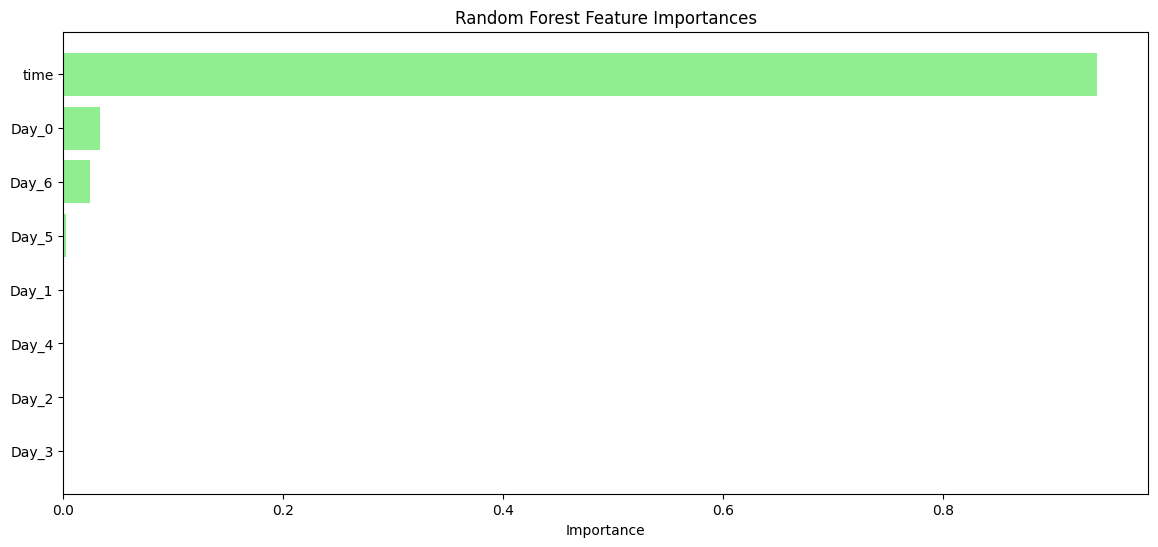

In [117]:
# Plot feature importances
plt.figure(figsize=(14, 6))

#plt.subplot(1, 2, 1)
#plt.barh(tree_importances['Feature'], tree_importances['Importance'], color='skyblue')
#plt.xlabel('Importance')
#plt.title('Decision Tree Feature Importances')
#plt.gca().invert_yaxis()

#plt.subplot(1, 2, 2)
plt.barh(rf_importances['Feature'], rf_importances['Importance'], color='lightgreen')
plt.xlabel('Importance')
plt.title('Random Forest Feature Importances')
plt.gca().invert_yaxis()
print("5")

In [118]:
plt.tight_layout()
plt.show()
print("6")

<Figure size 640x480 with 0 Axes>

6


In [119]:
#Calculating predictions
y_pred = shallow_rf.predict(X_test)

In [120]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

#Calculating loss function and metrics
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse:.2f}")

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R-squared: {r2:.4f}")

MSE: 3377.39
RMSE: 58.1153
MAE: 29.5915
R-squared: 0.0351


In [11]:
import logging
import sys
from codecarbon import EmissionsTracker
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
import numpy as np
import time


# --- TRAINING ---
tracker = EmissionsTracker(measure_power_secs=1,
    save_to_file=False,     # don’t create emissions.csv
    log_level="error"       # suppress INFO and WARNING messages
)
tracker.start()

# simple training workload
features = ['Day of Week', 'time']
target = 'Volume'
shallow_rf = RandomForestRegressor(n_estimators=50, max_depth=9, min_samples_leaf=2, min_samples_split=5, random_state=42)

start_time = time.time()  # Record start time
shallow_rf.fit(X_train, y_train)  # Train the model
end_time = time.time()  # Record end time

training_time = end_time - start_time  # Calculate elapsed time in seconds
print(f"Training time: {training_time:.2f} seconds")

# stop and read detailed fields
_kg_co2_train = tracker.stop()  # float (kg CO2eq)
train_data = tracker.final_emissions_data  # dataclass with energy_consumed, emissions, etc.

print("=== Training ===")
print(f"Energy consumed: {train_data.energy_consumed:.6f} kWh")
print(f"CO2 emissions:  {train_data.emissions:.6f} kg CO2eq")

# --- INFERENCE ON 1,000,000 EXAMPLES ---
#tracker = EmissionsTracker(measure_power_secs=1,
#    save_to_file=False,     # don’t create emissions.csv
#    log_level="error"       # suppress INFO and WARNING messages
#)
#tracker.start()

#X_test = np.random.randn(1000000, 100)
#_ = model.predict(X_test)

#_kg_co2_pred = tracker.stop()
#pred_data = tracker.final_emissions_data

#print("\n=== Prediction (per 1,000,000 examples) ===")
#print(f"Energy consumed: {pred_data.energy_consumed:.6f} kWh")
#print(f"CO2 emissions:  {pred_data.emissions:.6f} kg CO2eq")

Training time: 524.26 seconds
=== Training ===
Energy consumed: 0.007644 kWh
CO2 emissions:  0.003639 kg CO2eq


In [12]:
print("12")

12


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, PredefinedSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


df = pd.read_csv("Camera_Traffic_Counts2_20250918.csv", usecols=["Month", "Hour", "Minute", "Day of Week", "Speed Average (Miles Per Hour)", "Volume", "Read Date"])

df['time'] = df['Hour'] + df['Minute'] / 60
print(df.head(3))

features = ['Day of Week', 'time']
target = 'Volume'

train_df = df[df['Month'] <= 10]
test_df = df[df['Month'] > 10]

X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

#Hyperparamter Tuning
sample_size = 500000
train_sample = train_df.sample(n=sample_size, random_state=42)
X_train_sample = train_sample[features]
y_train_sample = train_sample[target]

tscv = TimeSeriesSplit(n_splits=3)

param_dist = {
    'n_estimators': [100, 200, 400],
    'max_depth': [6, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}

rf = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,
    scoring="neg_mean_squared_error",
    cv=tscv,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# 6. Run hyperparameter search on subset
random_search.fit(X_train_sample, y_train_sample)

# 3. Setup scoring metric (negative MAE for minimization)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# 4. Initialize Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Initialize and train models
shallow_rf = RandomForestRegressor(n_estimators=400, max_depth=6, min_samples_leaf=3, min_samples_split=2)
shallow_rf.fit(X_train, y_train)

# Get feature importances
rf_importances = pd.DataFrame({'Feature': features, 'Importance': shallow_rf.feature_importances_})

# Sort importances
rf_importances = rf_importances.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Plot feature importances
plt.figure(figsize=(14, 6))

plt.barh(rf_importances['Feature'], rf_importances['Importance'], color='lightgreen')
plt.xlabel('Importance')
plt.title('Random Forest Feature Importances')
plt.gca().invert_yaxis()
print("5")

plt.tight_layout()
plt.show()
print("6")